# Statistical Model for Electricity Price Forecasting

In this notebook I will attempt to use statistical time-series forecasting methods to predict wholesale electricity prices.

I will explore the ARMA, ARIMA and SARIMA models from the statsmodels package.
https://www.statsmodels.org/

I will be working with the electricity price data from the PJM Interconnection.

The PJM Interconnection is a regional transmission organization (RTO), that runs a competitive wholesale electricity market, coordinating producers and consumers across all or parts of 13 states and the District of Columbia. The interconnection contains over 11,000 nodes for which hourly day-ahead (DA) and real-time (RT) prices.

The data is obtained from: https://dataminer2.pjm.com/feed/rt_hrl_lmps
This feed contains hourly Real-Time Energy Market locational marginal pricing (LMP) data for all bus locations, including aggregates. 


In [1]:
%matplotlib inline

import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [2]:
# Read the CSV file into a dataframe
rt_lmp = pd.read_csv('rt_hrl_lmps.csv')  

In [3]:
rt_lmp.head()

,datetime_beginning_utc,datetime_beginning_ept,pnode_id,pnode_name,voltage,equipment,type,zone,system_energy_price_rt,total_lmp_rt,congestion_price_rt,marginal_loss_price_rt,row_is_current,version_nbr
0,1/1/2019 5:00:00 AM,1/1/2019 12:00:00 AM,1,PJM-RTO,NaN,NaN,ZONE,NaN,18.03,18.039782,0.0,0.008116,True,1
1,1/1/2019 6:00:00 AM,1/1/2019 1:00:00 AM,1,PJM-RTO,NaN,NaN,ZONE,NaN,17.77,17.775893,0.0,0.008393,True,1
2,1/1/2019 7:00:00 AM,1/1/2019 2:00:00 AM,1,PJM-RTO,NaN,NaN,ZONE,NaN,16.36,16.371294,0.0,0.007960,True,1
3,1/1/2019 8:00:00 AM,1/1/2019 3:00:00 AM,1,PJM-RTO,NaN,NaN,ZONE,NaN,12.27,12.279325,0.0,0.005159,True,1
4,1/1/2019 9:00:00 AM,1/1/2019 4:00:00 AM,1,PJM-RTO,NaN,NaN,ZONE,NaN,6.24,6.241449,0.0,0.002282,True,1


In [4]:
# Convert column to datetime
rt_lmp['datetime'] = pd.to_datetime(rt_lmp['datetime_beginning_ept'])
# Select the datetime and total LMP columns
rt_lmp = rt_lmp[['datetime','total_lmp_rt']]


In [5]:
rt_lmp.head()

,datetime,total_lmp_rt
0,2019-01-01 00:00:00,18.039782
1,2019-01-01 01:00:00,17.775893
2,2019-01-01 02:00:00,16.371294
3,2019-01-01 03:00:00,12.279325
4,2019-01-01 04:00:00,6.241449


In [6]:
# Select the training dataset for the forecast model
# The training data date range is taken as 7 days
mask = (rt_lmp['datetime'] >= '1/1/2019') & (rt_lmp['datetime'] < '1/8/2019')

rt_lmp_train = rt_lmp.loc[mask]

In [7]:
rt_lmp_train.head()

,datetime,total_lmp_rt
0,2019-01-01 00:00:00,18.039782
1,2019-01-01 01:00:00,17.775893
2,2019-01-01 02:00:00,16.371294
3,2019-01-01 03:00:00,12.279325
4,2019-01-01 04:00:00,6.241449


In [8]:
rt_lmp_train.tail()

,datetime,total_lmp_rt
163,2019-01-07 19:00:00,23.517063
164,2019-01-07 20:00:00,23.750980
165,2019-01-07 21:00:00,22.981034
166,2019-01-07 22:00:00,22.030669
167,2019-01-07 23:00:00,20.378479


(array([737060., 737061., 737062., 737063., 737064., 737065., 737066.,
        737067.]), <a list of 8 Text xticklabel objects>)

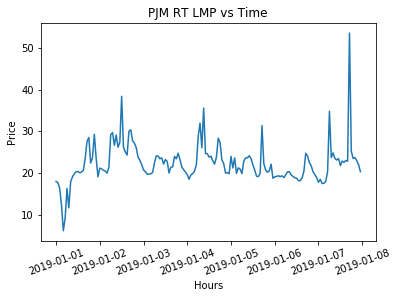

In [9]:
# Plot the LMP data
pd.plotting.register_matplotlib_converters()
plt.plot(rt_lmp_train['datetime'], rt_lmp_train['total_lmp_rt'])
plt.title("PJM RT LMP vs Time")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.xticks(rotation=20)

## Decomposition
The time series can be decomposed into its three constituent parts: trend, seasonality, and residual.

In [10]:
rt_lmp_train_val = rt_lmp_train['total_lmp_rt'].values

In [11]:
# Decomposition into Trend + Seasonal + Residual
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(rt_lmp_train_val, model='additive', freq=1)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

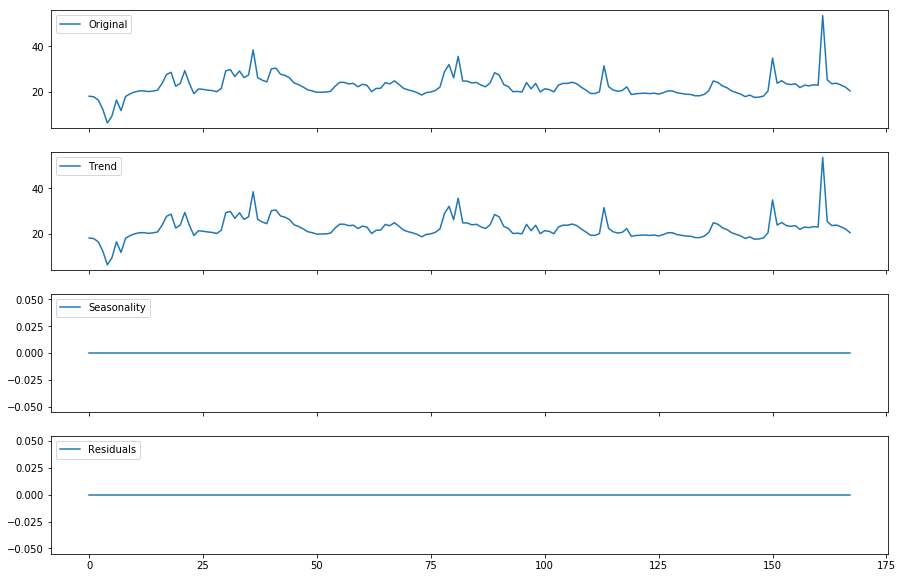

In [12]:
# Plot the decomposition results
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(rt_lmp_train_val, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

The entire series was taken as the trend component, and that there was no seasonality.
The residual plot shows zero. This indicates that the classical decomposition was not able to separate the data into its constituents.

Augmented Dickey-Fuller Test

This test helps to determin whether a time series is stationary or not.

* Null hypothesis: the series is nonstationary.
* Alternative hypothesis: the series is stationary.


In [13]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(rt_lmp_train_val)

In [14]:
# If the pvalue is less than 0.05, we reject the null that this data is nonstationary
print(pvalue)

8.518109603374794e-06


## ARMA model
The Autoregressive Moving Average model (ARMA) is a popular statistical model for time series forecasting.

* Autoregression: where the current value of the series depends linearly on its values in a number of previous time steps.
* Moving Average: where the current value of the series depends linearly on the mean and a set of previous error terms.

### ACF and PACF

We can use the Autocorrelation Function (ACF) to choose the order, known as q, of the MA model.
Similarly we can plot the Partial Autocorrelation Function (PACF) function to obtain the order p of the AR model

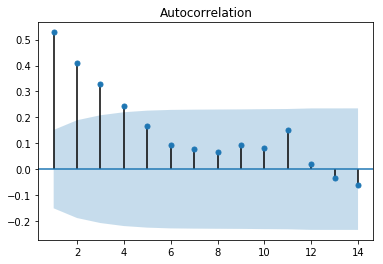

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

fig = plot_acf(rt_lmp_train_val, lags=range(1,15), alpha=0.05)

The blue region represents a confidence interval. Alpha in this case was set to 0.05 (95% confidence interval). 

The stems represent lagged correlation values. Correlations outside of the confidence interval are statistically significant whereas the others are not. 

Based on the ACF chart, we consider q = 4 order for the MA part.

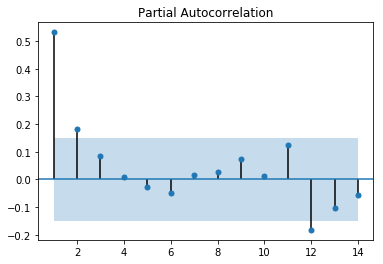

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf

fig = plot_pacf(rt_lmp_train_val, lags=range(1,15), alpha=0.05)

Based on the PACF chart, we consider p = 2 order for the AR part.

In [17]:
from statsmodels.tsa.arima_model import ARMA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [18]:
# We try to fit a ARMA model
arma_mod = ARMA(rt_lmp_train_val, (4, 2)).fit()

In [19]:
# Print Model Summary
print(arma_mod.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  168
Model:                     ARMA(4, 2)   Log Likelihood                -463.751
Method:                       css-mle   S.D. of innovations              3.767
Date:                Sat, 21 Mar 2020   AIC                            943.502
Time:                        18:44:48   BIC                            968.494
Sample:                             0   HQIC                           953.645
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.2871      0.800     27.875      0.000      20.720      23.854
ar.L1.y        1.5432      0.079     19.487      0.000       1.388       1.698
ar.L2.y       -1.2431      0.139     -8.938      0.0

In [20]:
# Print the model coefficients
arma_mod.params

array([22.28714808,  1.54321841, -1.24314594,  0.31967093,  0.08743474,
       -1.18437934,  0.99998096])

In [21]:
# Get the AIC
arma_mod.aic

943.5018998613668

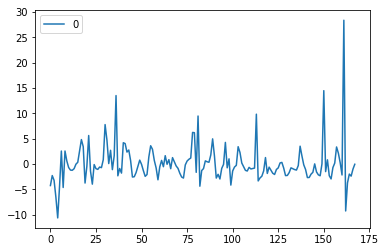

In [22]:
# plot residual errors
residuals = pd.DataFrame(arma_mod.resid)
residuals.plot()

In [23]:
# Get the test data set i.e. the next day
mask = (rt_lmp['datetime'] >= '1/8/2019') & (rt_lmp['datetime'] < '1/9/2019')

rt_lmp_test = rt_lmp.loc[mask]

rt_lmp_test_val = rt_lmp_test['total_lmp_rt'].values

In [24]:
# Make predictions for the train and test data
ypred = arma_mod.predict(start=1,end=len(rt_lmp_train_val)+len(rt_lmp_test_val))

In [25]:
# Fill initial portion with NaN to clearly display the out-of-sample predictions on the plot
oos = np.array(ypred, copy=True)
oos[0:192-24] = np.NaN

Text(0.5,1,'ARMA model results')

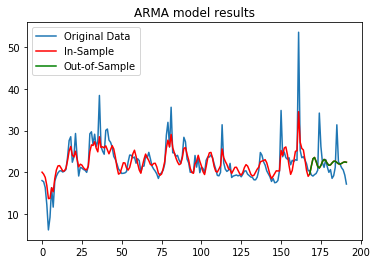

In [26]:
# Plot Original series, in-sample and out-of-sample predictions
x = rt_lmp.loc[(rt_lmp['datetime'] >= '1/1/2019') & (rt_lmp['datetime'] < '1/9/2019')]
x_val = x['total_lmp_rt'].values

plt.plot(x_val, label='Original Data')
plt.plot(ypred, color='red', label = 'In-Sample')
plt.plot(oos, color='green', label = 'Out-of-Sample')
plt.legend(loc='best')
plt.title('ARMA model results')

To confirm my choice of p and q, I use the arma_order_select_ic() method. 

This computes the selected information criteria (e.g. AIC or BIC) for many ARMA models, and gives us the model with the lowest value.

In [27]:
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm

res = sm.tsa.arma_order_select_ic(rt_lmp_train_val, ic='aic')
print('AIC =', res.aic_min_order)

AIC = (4, 2)


This matches the orders I had selected earlier.

## SARIMA

The ARIMA model consists of autoregressive, moving average and an integrated element. This allows for considering time series data that have a trend.

An extension to ARIMA is the SARIMA model, which considers a seasonal component (i.e. data with a repeating cycle).


I will use itertools to automate the model parameter search.

DigitalOcean.com has provided a good tutorial on this topic.

https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [28]:
import itertools

p = q = range(0, 3)
d = range(0, 2)
season = 24

# list of all parameter combos
pdq = list(itertools.product(p, d, q))

# same for seasonal variant
seasonal_pdq = [(x[0], x[1], x[2], season) for x in list(itertools.product(p, d, q))]

print('SARIMAX: {} , {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} , {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} , {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} , {}'.format(pdq[2], seasonal_pdq[4]))

SARIMAX: (0, 0, 1) , (0, 0, 1, 24)
SARIMAX: (0, 0, 1) , (0, 0, 2, 24)
SARIMAX: (0, 0, 2) , (0, 1, 0, 24)
SARIMAX: (0, 0, 2) , (0, 1, 1, 24)


In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [30]:
import warnings

# SARIMA search
warnings.filterwarnings("ignore") # specify to ignore warning messages

test_value = 10000 # Initialize value to some high number

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(rt_lmp_train_val,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()

            if results.aic < test_value:
                test_value = results.aic
                print('Lowest AIC so far: ARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
            
        except:
            continue

print("Done searching")

Lowest AIC so far: ARIMA(0, 0, 0),(0, 0, 0, 24) - AIC:1521.41219234872
Lowest AIC so far: ARIMA(0, 0, 0),(0, 0, 1, 24) - AIC:1194.7384058242542
Lowest AIC so far: ARIMA(0, 0, 0),(0, 1, 0, 24) - AIC:902.2796852075187
Lowest AIC so far: ARIMA(0, 0, 0),(0, 1, 1, 24) - AIC:679.0685657068511
Lowest AIC so far: ARIMA(0, 0, 0),(2, 1, 0, 24) - AIC:557.2802917680265
Lowest AIC so far: ARIMA(0, 0, 0),(2, 1, 1, 24) - AIC:556.0863789116665
Lowest AIC so far: ARIMA(0, 0, 1),(2, 1, 0, 24) - AIC:550.2657993280371
Lowest AIC so far: ARIMA(0, 0, 1),(2, 1, 1, 24) - AIC:550.1978558143883
Lowest AIC so far: ARIMA(0, 0, 2),(2, 1, 0, 24) - AIC:544.9255643189263
Lowest AIC so far: ARIMA(0, 1, 1),(2, 1, 0, 24) - AIC:536.9016211080504
Lowest AIC so far: ARIMA(0, 1, 1),(2, 1, 1, 24) - AIC:536.5712057794373
Lowest AIC so far: ARIMA(1, 0, 1),(2, 1, 0, 24) - AIC:534.4548580060668
Lowest AIC so far: ARIMA(1, 1, 1),(2, 1, 0, 24) - AIC:533.2767123252102
Lowest AIC so far: ARIMA(2, 0, 0),(2, 1, 0, 24) - AIC:529.916513

In [31]:
# We try to fit a SARIMA model
best_sar_mod = SARIMAX(rt_lmp_train_val,
                          order=(2,1,1),
                          seasonal_order=(2,1,0,24),
                          enforce_stationarity=False,
                          enforce_invertibility=False).fit()

In [32]:
# Summary
print(best_sar_mod.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  168
Model:             SARIMAX(2, 1, 1)x(2, 1, 0, 24)   Log Likelihood                -258.241
Date:                            Sat, 21 Mar 2020   AIC                            528.481
Time:                                    19:10:29   BIC                            543.677
Sample:                                         0   HQIC                           534.617
                                            - 168                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1528      0.220      0.696      0.487      -0.278       0.583
ar.L2          0.1723      0.188   

In [33]:
# Make predictions using SARIMA
ypred_sar = best_sar_mod.predict(start=1,end=len(rt_lmp_train_val)+len(rt_lmp_test_val))

Text(0.5,1,'ARMA model results')

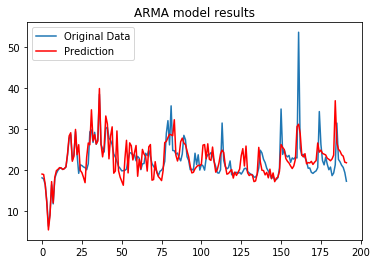

In [34]:
plt.plot(x_val, label='Original Data')
plt.plot(ypred_sar, color='red', label = 'Prediction')
plt.legend(loc='best')
plt.title('ARMA model results')

In [36]:
# Calculate Root Mean Squared Error for out-of-sample prediction
difference_array = np.subtract(ypred_sar[-24:],rt_lmp_test_val)
squared_array = np.square(difference_array)
mse = squared_array.mean()
rmse = np.sqrt(mse)
print('RMSE = ',rmse)

RMSE =  4.736483083365464


Electricity price forecasting can be challenging due to price spikes. Yet I have been able to use a SARIMA statistical time series model to obtain a decent prediction.